# Gold Prediction for Classification Model and Sentimental Analysis

# 1.Classification Model

In [1]:
# Import all libraries:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold 
from sklearn import linear_model, metrics 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression 
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, classification_report, make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler 
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE 
import statsmodels.api as sm 
from sklearn.svm import LinearSVC, SVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve 
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, RandomForestClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from itertools import product
from datetime import datetime
from sklearn.svm import SVR


%matplotlib inline



In [2]:
#Load the data
df1 = pd.read_csv("gld_price_data_Classification.csv") 
df1.head(5)

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [4]:
#Check any null or missing data. 
print("Total missing value of each column:\n{}".format(df1.isna().sum())) 
#No missing value in this data

Total missing value of each column:
Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64


## 1.1 Cleaning Data and Data Exploration

In [5]:
# Handle duplicate data
print("Before removing the duplicated data")
print("The duplicated records contain:", df1.duplicated().sum(),"records")
df1.drop_duplicates(keep='first', inplace = True)
print("After removing the duplicated data")
print("The duplicated records contain:", df1.duplicated().sum(),"records")

Before removing the duplicated data
The duplicated records contain: 0 records
After removing the duplicated data
The duplicated records contain: 0 records


In [6]:
#Observing the Overall information
df1.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [7]:
# RobustScaler is designed to be resistant to the influence of outliers in the data.
# Normalize Scaling with RobustScaler
X = df1.drop('Date', axis=1) 
rs = RobustScaler()
scaling_rs = rs.fit_transform(X)
df_rs = pd.DataFrame(scaling_rs, index=X.index, columns=X.columns)
df_rs.describe()
Xrb = df_rs.copy()

<Axes: >

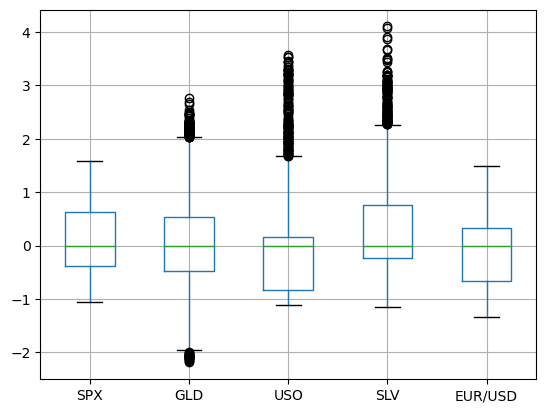

In [8]:
#Data Exploration, using Box plot
Xrb.boxplot()

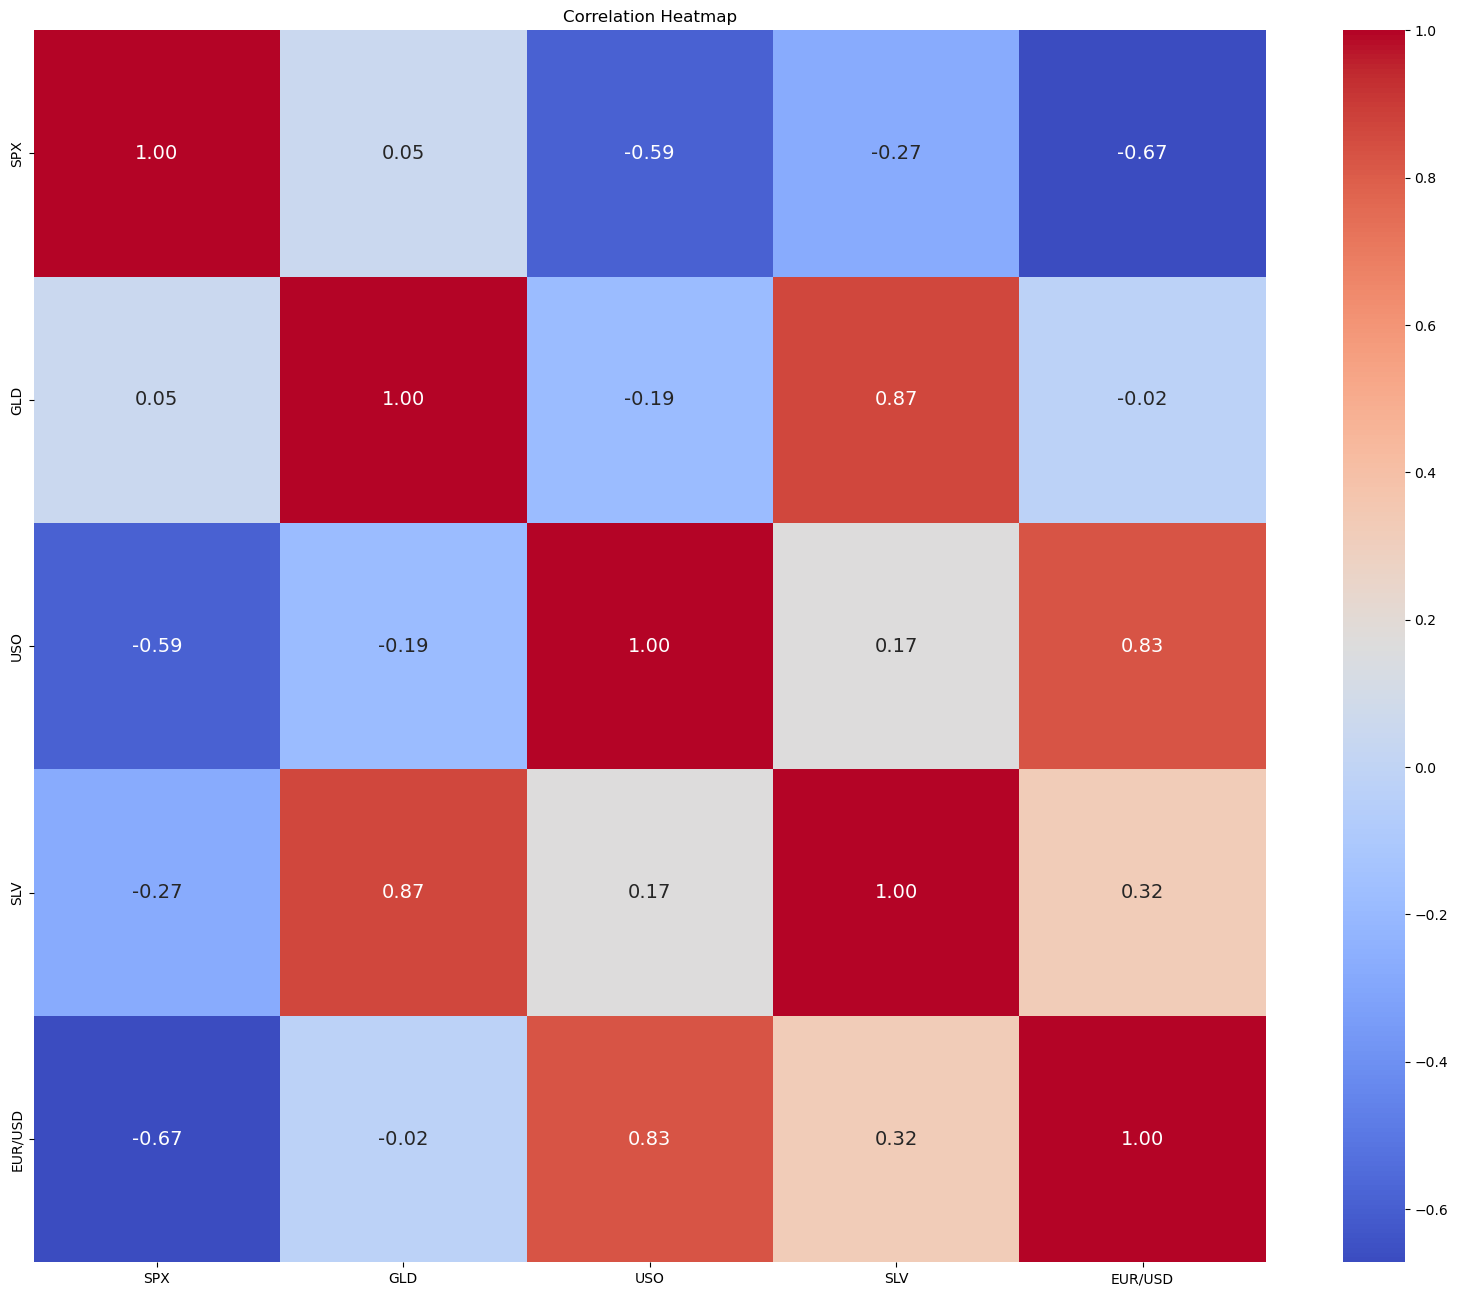

In [9]:
# Calculate the correlation matrix
correlation_matrix = Xrb.corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"size": 14}) #annot_kws sets font size
plt.title("Correlation Heatmap")
plt.show()

Histogram


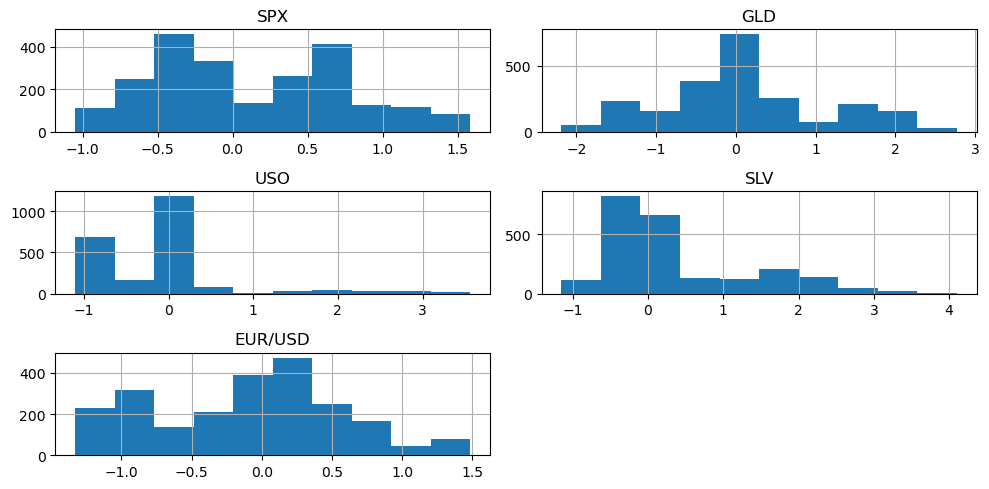

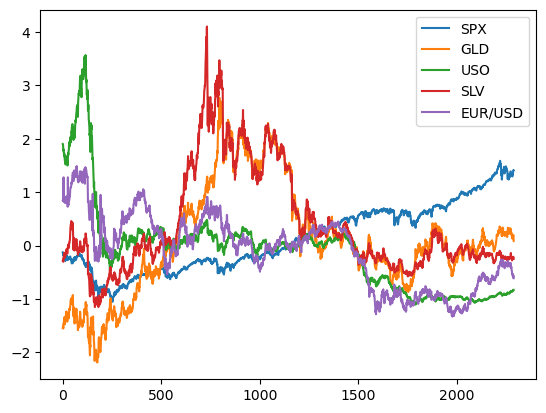

In [10]:
# Explore the Distribution of Gold price per gram by histogram
print('Histogram')
Xrb.hist(figsize=(10,5))
plt.tight_layout()
plt.show()

#Line chart show trend line of different independent variales
#Gold price's trend line is identical to silver price trend line, which is high correlation 
Xrb.plot()  
plt.show()


## 1.2 Classification Model and Evaluation

In [11]:
#Split the dataset with 25% as the test set with random state 42 and We already set X
X = df1.drop('Date', axis=1) 
y = df1.GLD

# split data into train+validation set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### R-Square

In [12]:
#Creating Pipeline models with different feature selection and scaling methods and classifiers
#Feature sections include VarianceThrashhold, Logisticregression selection, and Randomforest selection
feature_selections = [
    VarianceThreshold(threshold=0.25),
    SelectFromModel(RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42),threshold='median',max_features=2), 
]

#Scaling method include these three moethods
#1)Standard Scaler: normal distribution, cover 97% of data, SD -3 to 3
#2)Min Max Scaler: Max 1 and Min 0
#3)Robust scaler: cover 25% to 75% of all data

scaling_methods = [
    StandardScaler(), 
    MinMaxScaler(),
    RobustScaler()
]

#four regressors
classifiers = [
    KNeighborsRegressor(n_neighbors=3),
    RandomForestRegressor(n_estimators=120, max_depth=5, random_state=42),
    DecisionTreeRegressor(max_depth=5),
    AdaBoostRegressor(learning_rate=0.1, random_state=42)
]

# Create all list of all combinations
all_combinations = list(product(feature_selections, scaling_methods, classifiers))

# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection': [fs for fs in feature_selections], 
    'scaler': [scaler for scaler in scaling_methods],
    'classifier': [clf for clf in classifiers]
}

# Create the pipeline
pipeline = Pipeline([
    ('feature_selection', None),
    ('scaler', None),
    ('classifier', None)
])

# Define custom scorers for R^2 and RMSE
r2_scorer = make_scorer(r2_score)
rmse_scorer = make_scorer(mean_squared_error, squared=False)  

# Set up the grid search with five-fold cross-validation, using R^2 as scoring metric
clf_r2 = GridSearchCV(
    pipeline,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=r2_scorer
)

# Fit the grid search to your data
clf_r2.fit(X_train, y_train)

# Print the results
means_r2 = clf_r2.cv_results_['mean_test_score'] 
stds_r2 = clf_r2.cv_results_['std_test_score'] 
for index, (mean, std, params) in enumerate(zip(means_r2, stds_r2, clf_r2.cv_results_['params'])): 
    print(f'No {index + 1}')
    print("%0.4f (%0.04f) for %r" % (mean, std, params)) 
    print('*' * 100)


No 1
0.9988 (0.0002) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': VarianceThreshold(threshold=0.25), 'scaler': StandardScaler()}
****************************************************************************************************
No 2
0.9988 (0.0002) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': VarianceThreshold(threshold=0.25), 'scaler': MinMaxScaler()}
****************************************************************************************************
No 3
0.9990 (0.0002) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': VarianceThreshold(threshold=0.25), 'scaler': RobustScaler()}
****************************************************************************************************
No 4
0.9996 (0.0001) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': SelectFromModel(estimator=RandomForestRegressor(max_depth=5, n_estimators=10,
                                              

In [13]:
# Best parameters for R^2 (higher value of R^2 indicates the better of predictive accuaracy)
best_params_r2 = clf_r2.best_params_
best_score_r2 = clf_r2.best_score_
print("Best parameters for R^2:", best_params_r2)
print("The best accuracy:", best_score_r2) 

Best parameters for R^2: {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': SelectFromModel(estimator=RandomForestRegressor(max_depth=5, n_estimators=10,
                                                random_state=42),
                max_features=2, threshold='median'), 'scaler': MinMaxScaler()}
The best accuracy: 0.9995826464086696


### Root-Mean-Square-Error (RSME)

In [14]:
# Set up the grid search with five-fold cross-validation, using neg_mean_squared_error as scoring metric
clf_rmse = GridSearchCV(
    pipeline,
    param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=rmse_scorer
)

# Fit the grid search to your data
clf_rmse.fit(X_train, y_train)

# Get the best estimator
best_estimator_rmse = clf_rmse.best_estimator_

# Use the best estimator to make predictions
y_pred_rmse = best_estimator_rmse.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred_rmse, squared=False)

# Print the results
means_rmse = clf_rmse.cv_results_['mean_test_score'] 
stds_rmse = clf_rmse.cv_results_['std_test_score'] 
for index, (mean, std, params) in enumerate(zip(means_rmse, stds_rmse, clf_rmse.cv_results_['params'])): 
    print(f'No {index + 1}')
    print("%0.4f (%0.04f) for %r" % (mean, std, params)) 
    print('*' * 100)

No 1
0.8185 (0.0616) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': VarianceThreshold(threshold=0.25), 'scaler': StandardScaler()}
****************************************************************************************************
No 2
0.8188 (0.0554) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': VarianceThreshold(threshold=0.25), 'scaler': MinMaxScaler()}
****************************************************************************************************
No 3
0.7437 (0.0641) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': VarianceThreshold(threshold=0.25), 'scaler': RobustScaler()}
****************************************************************************************************
No 4
0.4770 (0.0809) for {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': SelectFromModel(estimator=RandomForestRegressor(max_depth=5, n_estimators=10,
                                              

In [15]:
# Find the index of the minimum RMSE score
min_rmse_index = np.argmin(means_rmse)

# Retrieve the corresponding parameters from param_grid
best_params_rmse = clf_rmse.cv_results_['params'][min_rmse_index]
best_score_rmse = means_rmse[min_rmse_index]

print("Best parameters for RMSE:", best_params_rmse)
print("RMSE score:", best_score_rmse)

# The best parameter between R-square and RMSE is the same, which is KNeighborsRegressor(n_neighbors=3), Feature selection from RandomForestRegressor,and MinMaxScaler
                                               

Best parameters for RMSE: {'classifier': KNeighborsRegressor(n_neighbors=3), 'feature_selection': SelectFromModel(estimator=RandomForestRegressor(max_depth=5, n_estimators=10,
                                                random_state=42),
                max_features=2, threshold='median'), 'scaler': MinMaxScaler()}
RMSE score: 0.4698702145110505


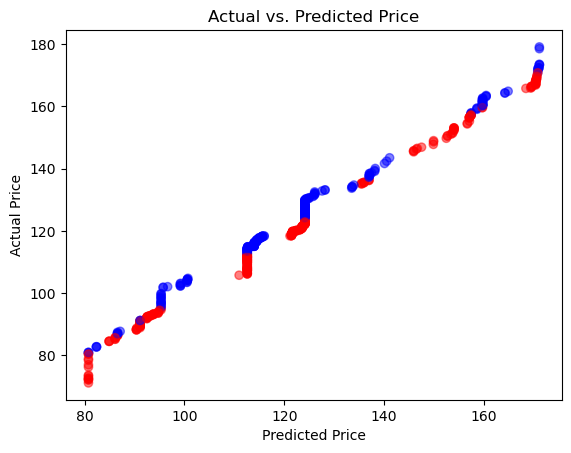

In [16]:
# Plot the prediction vs actual, to investigate the linear regression shape, 
# if it align to linear shape, it imply accuracy prediction

# Determine the color for each point based on the condition
colors = np.where(y_test > y_pred_rmse, 'blue', 'red')

# Create the scatter plot with different colors
plt.scatter(y_pred_rmse, y_test, color=colors, alpha=0.5)

# Add labels and title
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Actual vs. Predicted Price")

# Show plot
plt.show()

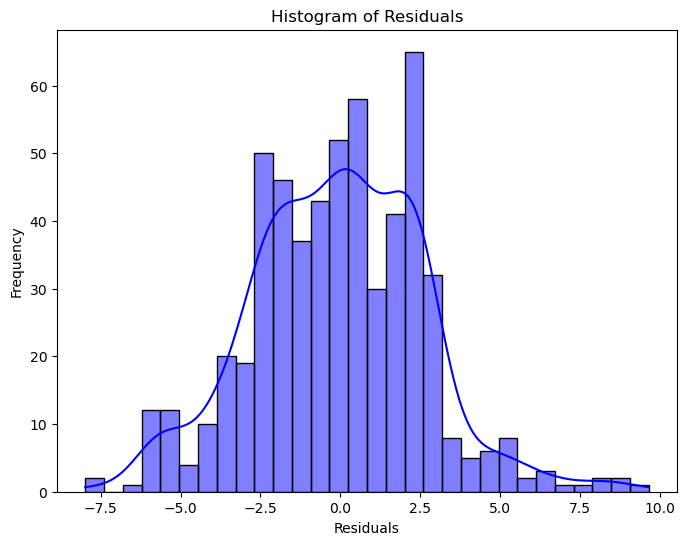

In [17]:
# Calculate the residuals
residuals = y_pred_rmse - y_test

# Plot the histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

Analyzing the histogram of residuals helps evaluate the performance and reliability of the regression model. A well-behaved histogram with symmetric indicates the model is perfoming accurate predictions. 

# 2.Sentimental Analysis

In [18]:
#import neccessary library for text analytics 
!pip install vaderSentiment

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix


# Download NLTK resources (stopwords and punkt tokenizer)
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stemming and stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
#Load the data
data = pd.read_csv("gold-dataset-sentimentalAnalysis.csv") 
data.head(5)

,Dates,URL,News,Price Direction Up,Price Direction Constant,Price Direction Down,Asset Comparision,Past Information,Future Information,Price Sentiment
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",0,0,1,0,1,0,negative
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,0,0,1,0,1,0,negative
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,0,0,0,1,0,positive
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...,0,0,0,0,0,1,none
4,06-09-2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",0,0,1,0,1,0,negative


## 2.1 Cleaning Data and Data Exploartion

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Dates                     10570 non-null  object
 1   URL                       10570 non-null  object
 2   News                      10570 non-null  object
 3   Price Direction Up        10570 non-null  int64 
 4   Price Direction Constant  10570 non-null  int64 
 5   Price Direction Down      10570 non-null  int64 
 6   Asset Comparision         10570 non-null  int64 
 7   Past Information          10570 non-null  int64 
 8   Future Information        10570 non-null  int64 
 9   Price Sentiment           10570 non-null  object
dtypes: int64(6), object(4)
memory usage: 825.9+ KB


In [21]:
#Select columns
df2 = pd.DataFrame(data, columns=["Dates","News","Price Sentiment"])

In [22]:
#Check any null or missing data. 
print("Total missing value of each column:\n{}".format(df2.isna().sum())) 
#No missing value in this data
df2.head(5)

Total missing value of each column:
Dates              0
News               0
Price Sentiment    0
dtype: int64


,Dates,News,Price Sentiment
0,28-01-2016,"april gold down 20 cents to settle at $1,116.1...",negative
1,13-09-2017,gold suffers third straight daily decline,negative
2,26-07-2016,Gold futures edge up after two-session decline,positive
3,28-02-2018,dent research : is gold's day in the sun comin...,none
4,06-09-2017,"Gold snaps three-day rally as Trump, lawmakers...",negative


In [23]:
#Delete the rows where all values are missing 
df2 = df2.dropna()     
print('Uncleaned dataset has {} data points with {} variables'.format(*df2.shape))
print("Check missing value of each column:\n{}".format(df2.isna().sum())) 

#Re-index
df2.reset_index(drop=True, inplace=True)

Uncleaned dataset has 10570 data points with 3 variables
Check missing value of each column:
Dates              0
News               0
Price Sentiment    0
dtype: int64


In [24]:
# Handling non-valid column names
df2.rename(columns={'Price Sentiment':'Sentiment'}, inplace=True)
df2.head(5)

,Dates,News,Sentiment
0,28-01-2016,"april gold down 20 cents to settle at $1,116.1...",negative
1,13-09-2017,gold suffers third straight daily decline,negative
2,26-07-2016,Gold futures edge up after two-session decline,positive
3,28-02-2018,dent research : is gold's day in the sun comin...,none
4,06-09-2017,"Gold snaps three-day rally as Trump, lawmakers...",negative


In [25]:
# Convert 'Dates' column to the mm/dd/yyyy format to match with df1's format
df2['Dates'] = pd.to_datetime(df2['Dates'], errors='coerce')
df2['Dates'] = df2['Dates'].dt.strftime('%m/%d/%Y')
df2.head(5)

C:\Users\admin\AppData\Local\Temp\ipykernel_4144\4256229010.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df2['Dates'] = pd.to_datetime(df2['Dates'], errors='coerce')


,Dates,News,Sentiment
0,01/28/2016,"april gold down 20 cents to settle at $1,116.1...",negative
1,09/13/2017,gold suffers third straight daily decline,negative
2,07/26/2016,Gold futures edge up after two-session decline,positive
3,02/28/2018,dent research : is gold's day in the sun comin...,none
4,06/09/2017,"Gold snaps three-day rally as Trump, lawmakers...",negative


In [26]:
# Convert the 'Dates' column to datetime format
df2['Dates'] = pd.to_datetime(df2['Dates'])
df2.info()

# Filter the scope of dates between 2008 and 2018
df2 = df2[(df2['Dates'].dt.year >= 2008) & (df2['Dates'].dt.year <= 2018)]

df2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Dates      10405 non-null  datetime64[ns]
 1   News       10570 non-null  object        
 2   Sentiment  10570 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 247.9+ KB


,Dates,News,Sentiment
0,2016-01-28,"april gold down 20 cents to settle at $1,116.1...",negative
1,2017-09-13,gold suffers third straight daily decline,negative
2,2016-07-26,Gold futures edge up after two-session decline,positive
3,2018-02-28,dent research : is gold's day in the sun comin...,none
4,2017-06-09,"Gold snaps three-day rally as Trump, lawmakers...",negative


In [27]:
#Remove none label and replace numerical value into text label
df2 = df2[(df2.Sentiment != "none")]
df2 = df2.replace({'Sentiment' : {'negative':-1, 'neutral':0, 'positive':1}})
df2.head(5)

,Dates,News,Sentiment
0,2016-01-28,"april gold down 20 cents to settle at $1,116.1...",-1
1,2017-09-13,gold suffers third straight daily decline,-1
2,2016-07-26,Gold futures edge up after two-session decline,1
4,2017-06-09,"Gold snaps three-day rally as Trump, lawmakers...",-1
5,2016-08-16,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",1


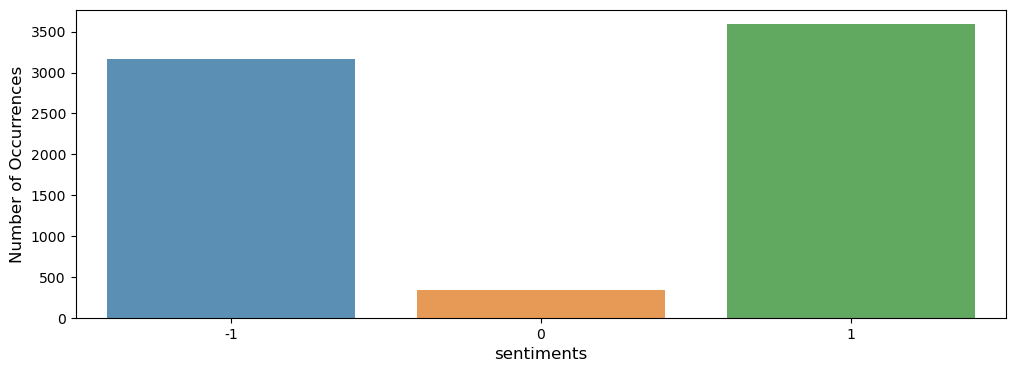

In [28]:
#Overall number of labels
sentiment = df2.Sentiment.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiments', fontsize=12)
plt.show();

In [29]:
# Define a function to preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # lowercase conversion, removing specific word, and removing duplicate tokens
    tokens = [token.lower() for token in tokens \
              if token.lower() not in ['gold','futures','dollar','prices','silver','data','ends','week','month','demand',\
                                       'global','session','trade']]
    tokens = list(set(tokens))  # Remove duplicate tokens
    
    # Stemming and filtering by word length, and removing numeric characters
    tokens = [stemmer.stem(token) for token in tokens if 3 <= len(token) <= 30 and not any(char.isdigit() for char in token)]
    
    return ' '.join(tokens)

# Apply preprocessing to the 'News' column
df2['Processed_News'] = df2['News'].apply(preprocess_text)

# Display the updated DataFrame
df2.head(5)

,Dates,News,Sentiment,Processed_News
0,2016-01-28,"april gold down 20 cents to settle at $1,116.1...",-1,down settl cent april
1,2017-09-13,gold suffers third straight daily decline,-1,declin third suffer daili straight
2,2016-07-26,Gold futures edge up after two-session decline,1,declin after edg two-sess
4,2017-06-09,"Gold snaps three-day rally as Trump, lawmakers...",-1,deal three-day trump debt-ceil snap reach rall...
5,2016-08-16,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",1,settl climb dec.


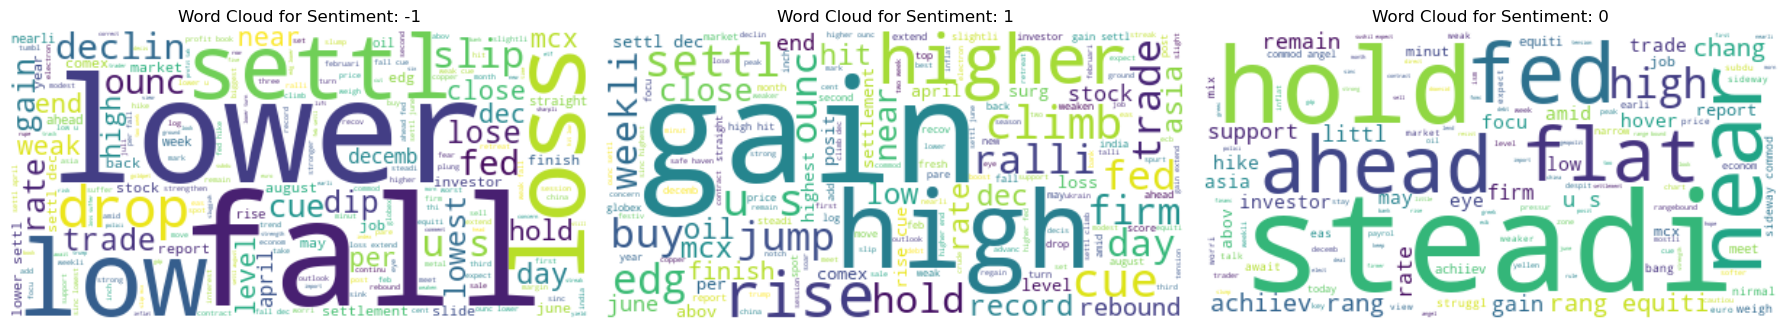

In [30]:
def generate_wordcloud(sentiment_category):
    # Combine all processed news into a single String base on sentiment 
    text = ' '.join(df2[df2['Sentiment'] == sentiment_category]['Processed_News'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for Sentiment: ' + str(sentiment_category))
    plt.axis('off')
    plt.show()

# Plot into 3 charts
sentiments = df2['Sentiment'].unique()
num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    ax = axes[i]
    # Combine all processed news text for the given sentiment category
    text = ' '.join(df2[df2['Sentiment'] == sentiment]['Processed_News'])
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    # Plot word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Word Cloud for Sentiment: ' + str(sentiment))
    ax.axis('off')

plt.tight_layout()
plt.show()

# as we can see, key words for each category well separate sentiment. For example, Fall, Loss, Low indicate a negetive sentiment,
# High, Gain Rise imply a positive sentiment and Steady, Flat, Hold indicate neutral sentiment.

## 2.2 Text Analysis 

In [31]:
#1.Using VADER sentimental analysis to predict sentiment

#Initialize and apply the VADER for sentimental analysis 
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to calculate sentiment scores
df2['Sentiment_Score'] = df2['Processed_News'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Convert sentiment scores to sentiment labels
df2['Predicted_Sentiment'] = df2['Sentiment_Score'].apply(lambda score: 1 if score > 0 else (-1 if score < 0 else 0))

# Compute and display VADER sentimental accuracy
vader_accuracy = (df2['Sentiment'] == df2['Predicted_Sentiment']).mean()
print("VADER Accuracy:", vader_accuracy)

# Accuracy is very low, we ignore this algorithm.

VADER Accuracy: 0.40572556762092793


In [32]:
# 2.Using rule-base sentimental analysis to predict sentiment

# Creating a function based on rules based sentiment
def rule_based_sentiment(text):
    # Split the text into words
    words = text.split()
    
    sentiment_score = 0
    
    # Define positive and negative keywords
    positive_words = ['gain','gains','high', 'rise','jump','higher','climb','record','hit','buy','ralli','ahead','edge','up','recovery','recoveri','rebound','rush','surg','surge','highest']
    negative_words = ['loss', 'fall','falls', 'drops', 'lose', 'declin', 'weak','dip','sell','lower','low','dec','down','snaps', 'suffer','red','slip']
    neutral_words = ['hold','steadi','flat','hover','sideways','steady','equiti']
    
    # Iterate over words and adjust sentiment score based on rules
    for word in words:
        if word in positive_words:
            sentiment_score += 1
        elif word in negative_words:
            sentiment_score -= 1
    
    # Determine sentiment label based on sentiment score
    if sentiment_score > 0:
        return 1
    elif sentiment_score < 0:
        return -1
    else:
        return 0

# Apply and display the rule-based sentimentimental analysis for prediction 
df2['Predicted_Sentiment'] = df2['Processed_News'].apply(rule_based_sentiment)
df2.head(10)

,Dates,News,Sentiment,Processed_News,Sentiment_Score,Predicted_Sentiment
0,2016-01-28,"april gold down 20 cents to settle at $1,116.1...",-1,down settl cent april,0.0000,-1
1,2017-09-13,gold suffers third straight daily decline,-1,declin third suffer daili straight,-0.3818,-1
2,2016-07-26,Gold futures edge up after two-session decline,1,declin after edg two-sess,0.0000,-1
4,2017-06-09,"Gold snaps three-day rally as Trump, lawmakers...",-1,deal three-day trump debt-ceil snap reach rall...,0.0258,1
5,2016-08-16,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",1,settl climb dec.,0.0000,1
6,2013-09-24,"gold falls by rs 25 on sluggish demand, global...",-1,sluggish cue fall,-0.4019,-1
7,2016-09-23,"Gold futures fall for the session, but gain fo...",1,the for gain but fall,0.2960,0
8,2012-10-21,"Gold struggles; silver slides, base metals falter",0,base struggl metal slide falter,0.0000,0
9,2018-03-16,"april gold holds slight gain, up $2.50, or 0.2...",1,gain slight hold april,0.5267,1
10,2009-04-02,"feb. gold ends up $9.60, or 1.1%, at $901.60 a...",1,feb. ounc,0.0000,0


In [33]:
# Compute and display Rule-base sentimental accuracy
ruleBase_sentimental_accuracy = (df2['Sentiment'] == df2['Predicted_Sentiment']).mean()
print("Rule-base sentiment accuracy:", ruleBase_sentimental_accuracy)
# Accuracy is better than first model, however it does not perform well.

Rule-base sentiment accuracy: 0.676350303201241


In [34]:
# 3.Using RandomForest Classifier to predict sentiment

# Prepare the data
X = df2['Processed_News']  # Features
y = df2['Sentiment']  # Target variable

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# Using TF-IDF to create vector table 
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_rf)
X_test_vectorized = vectorizer.transform(X_test_rf)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_vectorized, y_train_rf)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_vectorized)

rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)
print("RandomForest Accuracy:", rf_accuracy)

#This model displays an excellent performance in term of accuracy. 

RandomForest Accuracy: 0.9252995066948555


In [35]:
# 4. Using RandomForest Classifier to predict sentiment by applying cross validation 5 folds for comparing the result with the train and test split of sampling

# Initialize RandomForest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(rf_classifier, X_train_vectorized, y_train_rf, cv=5)
print("Cross-Validation Scores:", cv_scores)

# Calculate the mean accuracy of cross-validation
mean_cv_accuracy = cv_scores.mean()
print("Mean Cross-Validation Accuracy:", mean_cv_accuracy)

# Identical result between cross validation and train-test split.

Cross-Validation Scores: [0.89955947 0.91629956 0.91534392 0.92151675 0.91005291]
Mean Cross-Validation Accuracy: 0.9125545222167837


## 2.3 Evaluation

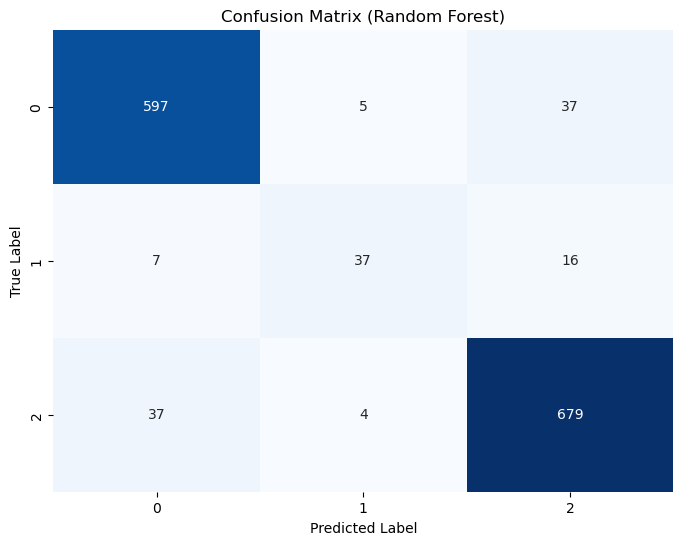

In [36]:
# 1. Compute confusion matrix from RandomForest Classifier
conf_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

# This model well classify the positive and negative sentiment, Although, poor performance for neutral label of prediction. 

In [37]:
# 2. Classification Report
print("Classification Report:")
print(classification_report(y_test_rf, y_pred_rf))

#Overall, the model performs well with high precision, recall, and F1-score for positive and negative sentiments. 
#However, for neutral sentiment, although precision is decent, recall is comparatively lower. 
#The accuracy of the model is 93%, indicating strong overall performance.

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.93      0.93       639
           0       0.80      0.62      0.70        60
           1       0.93      0.94      0.94       720

    accuracy                           0.93      1419
   macro avg       0.89      0.83      0.86      1419
weighted avg       0.92      0.93      0.92      1419



# 3. Combination of Classification datasets and Sentimental dataset


## 3.1 Cleaning dataset and integreat two datasets

In [38]:
# Transform df2's date into the identical format (Month/day/year) with Df1's date and select the same period (2008 - 2018) 
# Convert 'Date' column in df1 to datetime
df1['Dates'] = pd.to_datetime(df1['Date'])

# Drop 'Date' column after merging
df1.drop('Date', axis=1, inplace=True)

# Reduce the dates in df2 by one day because news might has time lag incomparison with Gold price dataset
df2['Dates'] = df2['Dates'] - pd.Timedelta(days=1)

df2.head(5)

,Dates,News,Sentiment,Processed_News,Sentiment_Score,Predicted_Sentiment
0,2016-01-27,"april gold down 20 cents to settle at $1,116.1...",-1,down settl cent april,0.0000,-1
1,2017-09-12,gold suffers third straight daily decline,-1,declin third suffer daili straight,-0.3818,-1
2,2016-07-25,Gold futures edge up after two-session decline,1,declin after edg two-sess,0.0000,-1
4,2017-06-08,"Gold snaps three-day rally as Trump, lawmakers...",-1,deal three-day trump debt-ceil snap reach rall...,0.0258,1
5,2016-08-15,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",1,settl climb dec.,0.0000,1


In [39]:
#One-hot coding
# Merge the two datasets on the 'Dates' column after renaming in df1
#df3 = pd.merge(df1, df2[['Dates', 'Sentiment']], left_on='Dates', right_on='Dates', how='inner')

# Transform 'Sentiment' column into original form
# df3 = df3.replace({'Sentiment' : {-1:'negative', 0:'neutral', 1:'positive'}})
# df3.head(5)

# Creating for 'Sentiment' column
# df3 = pd.get_dummies(df3, columns=['Sentiment'])
# df3.head(5)

In [40]:
# Merge the two datasets on the 'Dates' column after renaming in df1
df3 = pd.merge(df1, df2[['Dates', 'Sentiment']], left_on='Dates', right_on='Dates', how='inner')
df3.head(5)

,SPX,GLD,USO,SLV,EUR/USD,Dates,Sentiment
0,1447.160034,85.570000,78.370003,15.285,1.474491,2008-01-03,-1
1,1447.160034,85.570000,78.370003,15.285,1.474491,2008-01-03,-1
2,1416.180054,84.769997,75.500000,15.053,1.468299,2008-01-07,1
3,1416.180054,84.769997,75.500000,15.053,1.468299,2008-01-07,-1
4,1409.130005,86.550003,75.250000,15.520,1.466405,2008-01-09,1


In [41]:
#Check any null or missing data. 
print("Total missing value of each column:\n{}".format(df1.isna().sum())) 

Total missing value of each column:
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
Dates      0
dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_4144\3618270323.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df3.corr()


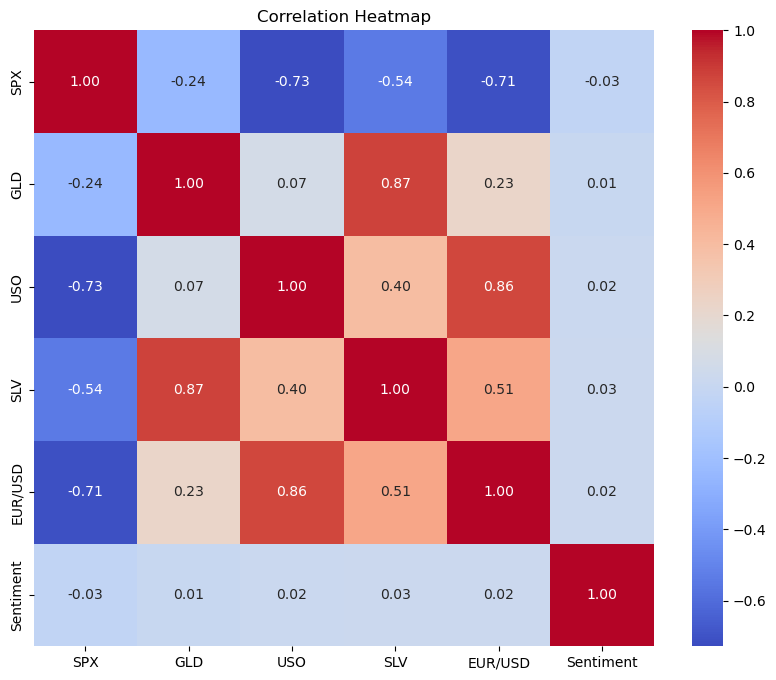

In [42]:
# Compute the correlation matrix
corr_matrix = df3.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## 3.2 Apply Model to predict Gold Price

In [43]:
# Define the start and end dates for the training and test sets
# Using all data from 2008 - 2016 for training set (68%) and using all data from 2017 - 2018 for testset (32%)
train_start_date = datetime(2008, 1, 1)
train_end_date = datetime(2016, 12, 31)
test_start_date = datetime(2017, 1, 1)
test_end_date = datetime(2018, 12, 31)

# Filter the dataset to get the training and test sets
train_set_c = df3[(df3['Dates'] >= train_start_date) & (df3['Dates'] <= train_end_date)]
test_set_c = df3[(df3['Dates'] >= test_start_date) & (df3['Dates'] <= test_end_date)]

# Display the shapes of the training and test sets
print("Training set shape:", train_set_c.shape)
print("Test set shape:", test_set_c.shape)

Training set shape: (3116, 7)
Test set shape: (1552, 7)


In [44]:
# training and testing split by using all features
X_train_c = train_set_c.drop(['GLD', 'Dates'], axis=1)
y_train_c = train_set_c['GLD']

X_test_c = test_set_c.drop(['GLD', 'Dates'], axis=1)
y_test_c = test_set_c['GLD']

# Initialize and train the Random Forest model
rf_model_c = RandomForestRegressor()
rf_model_c.fit(X_train_c, y_train_c)

# Predict on the test set
y_pred_c = rf_model_c.predict(X_test_c)


R-squared: -6.090070304750605
RMSE: 9.799920945023647


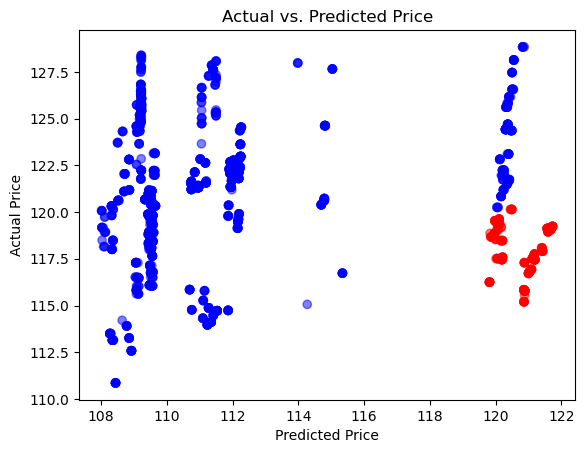

In [45]:
# Determine the color for each point based on the condition (Blue:actual, Red: Prediction)
colors = np.where(y_test_c > y_pred_c, 'blue', 'red')

# Create the scatter plot with different colors
plt.scatter(y_pred_c, y_test_c, color=colors, alpha=0.5)

# Add labels and title
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Actual vs. Predicted Price")

# Show plot
plt.show()

#We cannot use sentiment of gold news to predict Gold price because:
#1.News headline provide price direction as different period of time that does not compare to yesterday price.
# Dates for sentimental dataset was a released date of news. Typically, they analyzed or summarized data from different period such as monthly, quarterly, yearly report.
#2.In this dataset, they retrieve data from several URL that might has a data conflict between several sources in each day for example one source positive another source negative.



## 3.3 Gold price prediction between 2017 - 2018 from different scenarios by using training dataset from 2008 - 2016 

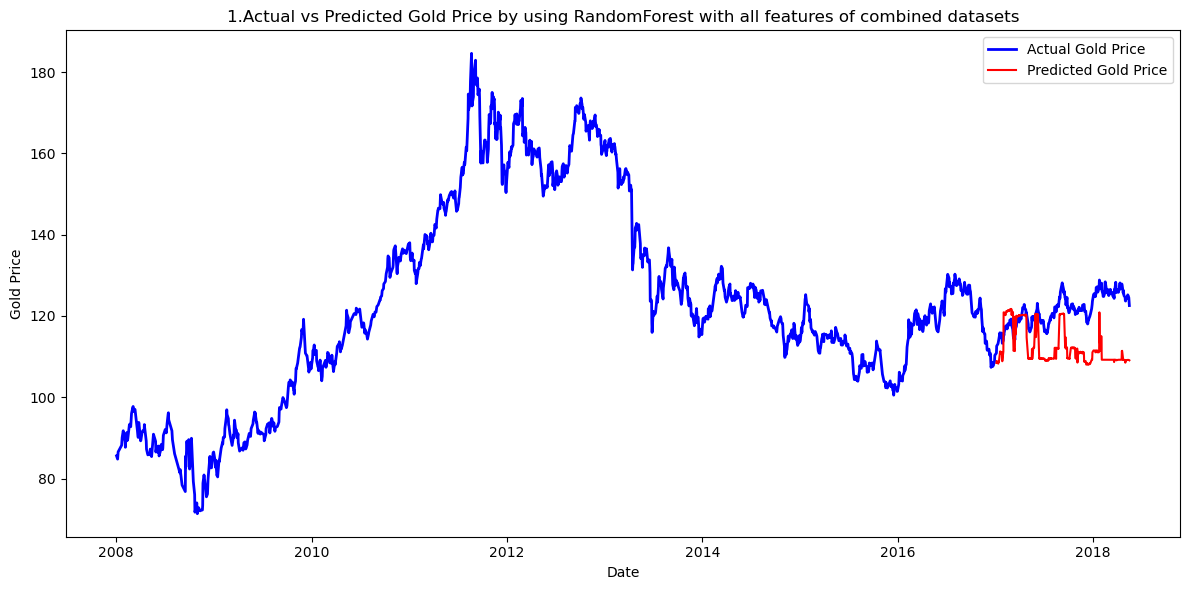

R-squared: -6.090070304750605
RMSE: 9.799920945023647


In [52]:
# 1.Actual vs Predicted Gold Price from combined dataset (using all features)
# Set figure size
plt.figure(figsize=(12, 6))

# Plotting the lines
plt.plot(df3['Dates'], df3['GLD'], color='blue', linewidth=2, linestyle='-', label='Actual Gold Price')
plt.plot(test_set_c['Dates'], y_pred_c, color='red', label='Predicted Gold Price')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('1.Actual vs Predicted Gold Price by using RandomForest with all features of combined datasets')
plt.legend()
plt.tight_layout()
plt.show()

#Evaluation
# Calculate R-squared
r2_s1 = r2_score(y_test_c, y_pred_c)

# Calculate RMSE
rmse_s1 = np.sqrt(mean_squared_error(y_test_c, y_pred_c))

# Print R-squared and RMSE
print("R-squared:", r2_s1)
print("RMSE:", rmse_s1)

Selected feature names: Index(['SPX', 'SLV'], dtype='object')


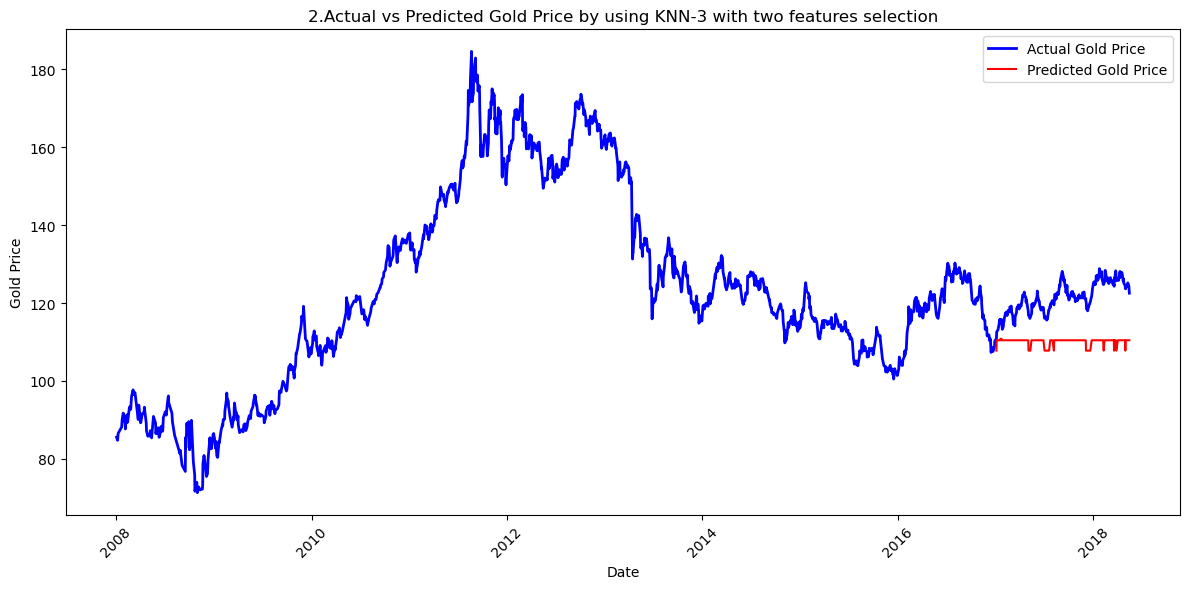

R-squared: -8.171707091986953
RMSE: 11.146086004264632


In [53]:
# 2.Actual vs Predicted Gold Price from combined dataset (using two features that include 'SPX stock','Silver price' from first dataset) 
# Define the best model from classification model
classifier = {
    'regressor': KNeighborsRegressor(n_neighbors=3),
    'feature_selection': SelectFromModel(estimator=RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42), threshold='median', max_features=2),
    'scaler': MinMaxScaler()
}

# Preprocess features
X_train_scaled = classifier['scaler'].fit_transform(X_train_c)
X_train_selected = classifier['feature_selection'].fit_transform(X_train_scaled, y_train_c)

# Get names of selected features
selected_feature_indices = classifier['feature_selection'].get_support(indices=True)
selected_feature_names = X_train_c.columns[selected_feature_indices]
print("Selected feature names:", selected_feature_names)

# Train the model
classifier['regressor'].fit(X_train_selected, y_train_c)

# Preprocess test features
X_test_scaled = classifier['scaler'].transform(X_test_c)
X_test_selected = classifier['feature_selection'].transform(X_test_scaled)
# Feature selection incorperates SPX and SLV columns from first dataset 

# Predict on the test set
y_pred_s2 = classifier['regressor'].predict(X_test_selected)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df3['Dates'], df3['GLD'], color='blue', linewidth=2, linestyle='-', label='Actual Gold Price')
plt.plot(test_set_c['Dates'], y_pred_s2, color='red', label='Predicted Gold Price')

plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('2.Actual vs Predicted Gold Price by using KNN-3 with features selection')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Evaluation
# Calculate R^2 score
r2_s2 = r2_score(y_test_c, y_pred_s2)

# Calculate RMSE
rmse_s2 = mean_squared_error(y_test_c, y_pred_s2, squared=False)

print("R-squared:", r2_s2)
print("RMSE:", rmse_s2)

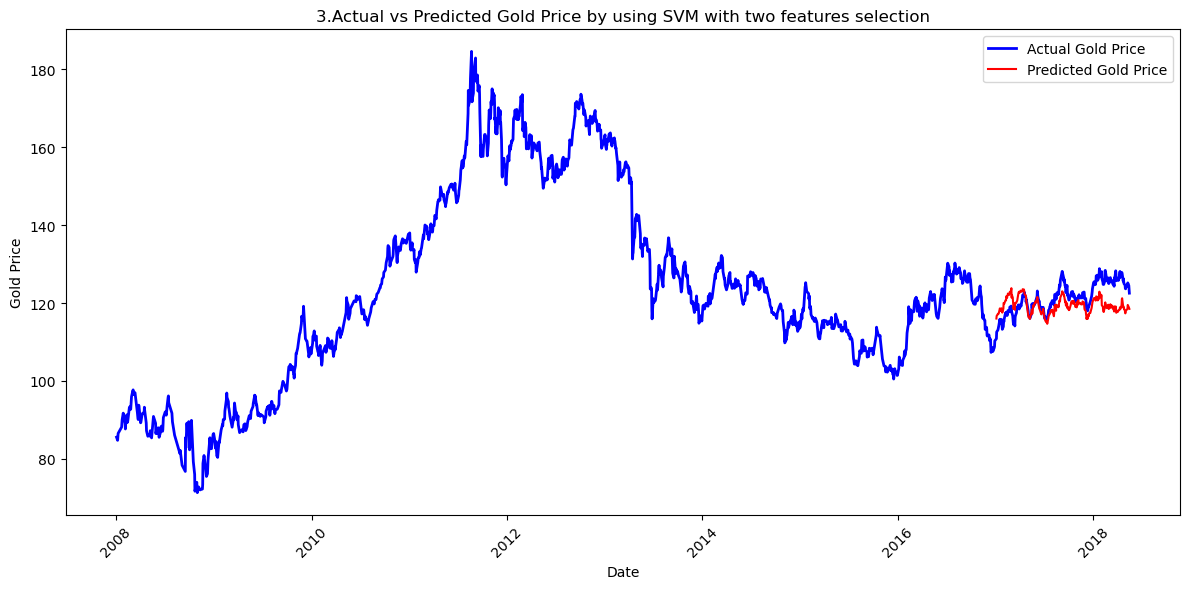

R-squared: 0.0029019903847405937
RMSE: 3.6750751663301937


In [57]:
# 3.Actual vs Predicted Gold Price from combined dataset (using two features that include 'SPX','SLV' from first dataset)
# Using SVM
classifier = {
    'regressor': SVR(kernel='rbf', C=100, gamma=0.1),
    'feature_selection': SelectFromModel(estimator=RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42), threshold='median', max_features=2),
    'scaler': MinMaxScaler()
}

# Preprocess features
X_train_scaled = classifier['scaler'].fit_transform(X_train_c)
X_train_selected = classifier['feature_selection'].fit_transform(X_train_scaled, y_train_c)

# Train the model
classifier['regressor'].fit(X_train_selected, y_train_c)

# Preprocess test features
X_test_scaled = classifier['scaler'].transform(X_test_c)
X_test_selected = classifier['feature_selection'].transform(X_test_scaled)

# Predict on the test set
y_pred_s3 = classifier['regressor'].predict(X_test_selected)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df3['Dates'], df3['GLD'], color='blue', linewidth=2, linestyle='-', label='Actual Gold Price')
plt.plot(test_set_c['Dates'], y_pred_s3, color='red', label='Predicted Gold Price')

plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('3.Actual vs Predicted Gold Price by using SVM with features selection')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Evaluation
# Calculate R^2 score
r2_s3 = r2_score(y_test_c, y_pred_s3)

# Calculate RMSE
rmse_s3 = mean_squared_error(y_test_c, y_pred_s3, squared=False)

print("R-squared:", r2_s3)
print("RMSE:", rmse_s3)


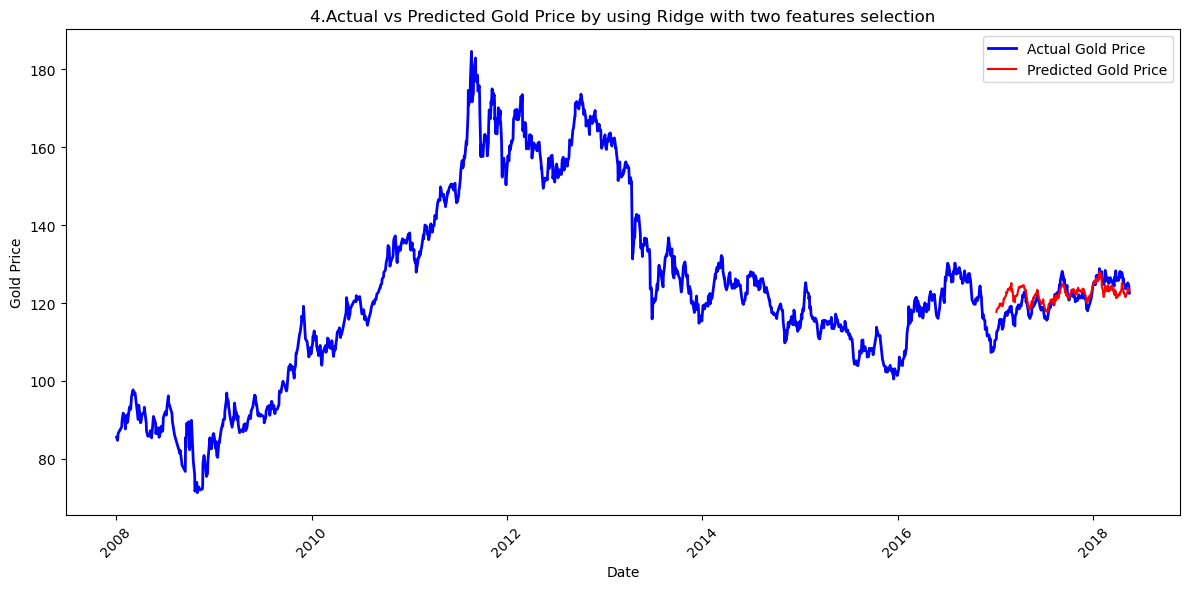

R-squared: 0.3436149639319451
RMSE: 2.9817871396122944


In [59]:
# 4.Actual vs Predicted Gold Price from combined dataset (using two features that include 'SPX','SLV' from first dataset)
# Using Ridge (Ridge regression is a linear regression model that includes a regularization term to prevent overfitting)

from lightgbm import LGBMRegressor
classifier = {
    'regressor': Ridge(alpha=1.0),
    'feature_selection': SelectFromModel(estimator=RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42), threshold='median', max_features=2),
    'scaler': MinMaxScaler()
}

# Preprocess features
X_train_scaled = classifier['scaler'].fit_transform(X_train_c)
X_train_selected = classifier['feature_selection'].fit_transform(X_train_scaled, y_train_c)

# Train the model
classifier['regressor'].fit(X_train_selected, y_train_c)

# Preprocess test features
X_test_scaled = classifier['scaler'].transform(X_test_c)
X_test_selected = classifier['feature_selection'].transform(X_test_scaled)

# Predict on the test set
y_pred_s4 = classifier['regressor'].predict(X_test_selected)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df3['Dates'], df3['GLD'], color='blue', linewidth=2, linestyle='-', label='Actual Gold Price')
plt.plot(test_set_c['Dates'], y_pred_s4, color='red', label='Predicted Gold Price')

plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('4.Actual vs Predicted Gold Price by using Ridge with features selection')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Evaluation
# Calculate R^2 score
r2_s4 = r2_score(y_test_c, y_pred_s4)

# Calculate RMSE
rmse_s4 = mean_squared_error(y_test_c, y_pred_s4, squared=False)

print("R-squared:", r2_s4)
print("RMSE:", rmse_s4)

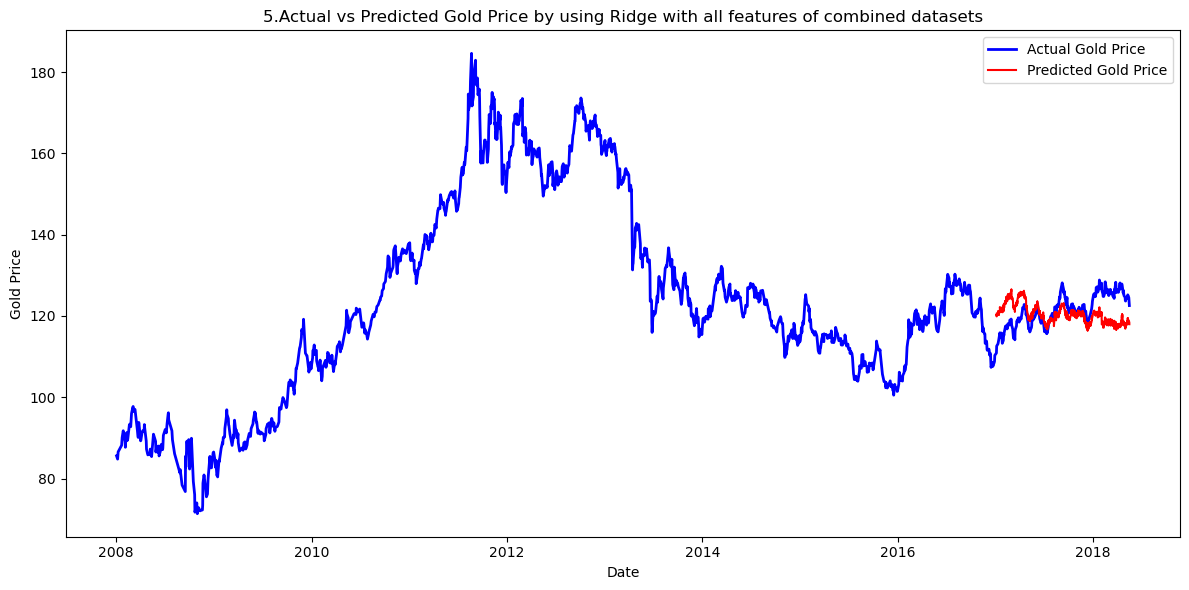

R-squared: -0.5641905530592257
RMSE: 4.603012251145753


In [60]:
# 5.Actual vs Predicted Gold Price from combined dataset (using all features with Ridge regression)

# Initialize and train the Random Forest model
ridge_model = Ridge()
ridge_model.fit(X_train_c, y_train_c)

# Predict on the test set
y_pred_s5 = ridge_model.predict(X_test_c)

# 1.Actual vs Predicted Gold Price from combined dataset (using all features)
# Set figure size
plt.figure(figsize=(12, 6))

# Plotting the lines
plt.plot(df3['Dates'], df3['GLD'], color='blue', linewidth=2, linestyle='-', label='Actual Gold Price')
plt.plot(test_set_c['Dates'], y_pred_s5, color='red', label='Predicted Gold Price')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('5.Actual vs Predicted Gold Price by using Ridge with all features of combined datasets')
plt.legend()
plt.tight_layout()
plt.show()

#Evaluation
# Calculate R-squared
r2_s5 = r2_score(y_test_c, y_pred_s5)

# Calculate RMSE
rmse_s5 = np.sqrt(mean_squared_error(y_test_c, y_pred_s5))

# Print R-squared and RMSE
print("R-squared:", r2_s5)
print("RMSE:", rmse_s5)

In [65]:
# Summary of five different scenarios
scenario_results = {
    "Scenario": ["RandomForest with all features", "KNN-3 with features selection", "SVM with features selection", 
                 "Ridge with features selection", "Ridge with all features"],
    "R-squared": [r2_s1, r2_s2, r2_s3, r2_s4, r2_s5],
    "RMSE": [rmse_s1, rmse_s2, rmse_s3, rmse_s4, rmse_s5]
}

# Create a DataFrame 
results_df = pd.DataFrame(scenario_results)

# Add ranking based on RMSE
results_df['Rank (RMSE)'] = results_df['RMSE'].rank(ascending=True).astype(int)

# Sort by RMSE values
results_df_sorted_rmse = results_df.sort_values(by='RMSE', ascending=True)

# Display the sorted with ranking
results_df_sorted_rmse

,Scenario,R-squared,RMSE,Rank (RMSE)
3,Ridge with features selection,0.343615,2.981787,1
2,SVM with features selection,0.002902,3.675075,2
4,Ridge with all features,-0.564191,4.603012,3
0,RandomForest with all features,-6.090070,9.799921,4
1,KNN-3 with features selection,-8.171707,11.146086,5


In conclusion, Ridge regression with feature selection excellently performs in predicting gold prices compared to other models tested. RandomForest with all features performs poorly, indicating that including irrelevant features can degrade model performance. Additionally, KNN-3 with features selection has the highest prediction errors, implying that this model might not be adequate for predictive gold price.